In [110]:
from pathlib import Path
import cfgrib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import datetime
import xarray as xr
from typing import Union
import numcodecs

This notebook is research for [GitHub issue #344: Convert NWP grib files to Zarr intermediate](https://github.com/openclimatefix/nowcasting_dataset/issues/344).

Useful links:

* [Met Office's data docs](http://cedadocs.ceda.ac.uk/1334/1/uk_model_data_sheet_lores1.pdf)

Known differences between the old Zarr (UKV__2018-01_to_2019-12__chunks__variable10__init_time1__step1__x548__y704__.zarr) and the new zarr:

* Images in the old zarr were top-to-bottom.  Images in the new Zarr follow the ordering in the grib files: bottom-to-top.
* The x and y coordinates are different by 1km each.
* The new Zarr is float16?
* The new Zarr has a few more variables.

Done:

* Merge Wholesale1 and 2 (2 includes dswrf, lcc, mcc, and hcc)
* Remove dimensions we don't care about (e.g. select temperature at 1 meter, not 0 meters)
* Reshape images from 1D to 2D.
* Do we really need to convert datetimes to unix epochs before appending to zarr?  If no, submit a bug report.
* eccodes takes ages to load multiple datasets from each grib.  Maybe it'd be faster to pre-load each grib into ramdisk?  UPDATE: Nope, it's not faster!  What does give a big speedup, though, is using an idx file!
* Reshaping is pretty slow.  Maybe go back to using `np.reshape`?
* Experiment with when it might be fastest to load data into memory.
* Remove `wholesale_file_number`.  And then use a `pd.Series` instead of a DF.
* Zarr chunk size and compression.
* Write to leonardo's SSD
* Do we need to combine all the DataArrays into a single DataArray (with "variable" being a dimension?).  The upside is that then a single Zarr chunk can include multiple variables.  The downside is that we lose the metadata (but that's not a huge problem, maybe?)
* Convert to float16?

Some outstanding questions / Todo items


* Experiment with compression
* Load some data to make sure float16 is fine!
* Separately log "bad files" to a CSV file?
* Restart from last `time` in existing Zarr.
* Check for NaNs.  cdcb has NaNs.
* Parallelise
* Convert to script
* Use click to set source and target directories



In [65]:
# Define geographical domain for UKV.
# Taken from page 4 of http://cedadocs.ceda.ac.uk/1334/1/uk_model_data_sheet_lores1.pdf
# To quote the PDF:
# "The United Kingdom domain is a 1,096km x 1,408km ~2km resolution grid.
# The OS National Grid corners of the domain are:"

DY_METERS = DX_METERS = 2_000
NORTH = 1223_000
SOUTH = -185_000
WEST = -239_000 
EAST = 857_000

# Note that the UKV NWPs y is top-to-bottom
NORTHING = np.arange(start=NORTH, stop=SOUTH, step=-DY_METERS, dtype=np.int32)
EASTING = np.arange(start=WEST, stop=EAST, step=DX_METERS, dtype=np.int32)

NUM_ROWS = len(NORTHING)
NUM_COLS = len(EASTING)

In [3]:
# NWP_PATH = Path("/home/jack/Data/NWP/01")
# NWP_PATH = Path("/media/jack/128GB_USB/NWPs")  # Must not include trailing slash!!!
NWP_PATH = Path("/mnt/storage_b/data/ocf/solar_pv_nowcasting/nowcasting_dataset_pipeline/NWP/UK_Met_Office/UKV/native")

In [4]:
assert NWP_PATH.exists()

In [ ]:
print("Getting list of all filenames...")

In [5]:
filenames = list(NWP_PATH.glob("*/*/*/*Wholesale[12].grib"))

In [6]:
print("Got", len(filenames), "filenames")

57

In [7]:
def grib_filename_to_datetime(full_filename: Path) -> datetime.datetime:
    """Parse the grib filename and return the datetime encoded in the filename.
    
    Returns a datetime.
      For example, if the filename is '202101010000_u1096_ng_umqv_Wholesale1.grib',
      then the returned datetime will be datetime(year=2021, month=1, day=1, hour=0, minute=0).
      
    Raises RuntimeError if the filename does not match the expected regex pattern.
    """
    # Get the base_filename, which will be of the form '202101010000_u1096_ng_umqv_Wholesale1.grib'
    base_filename = full_filename.name

    # Use regex to match the year, month, day, hour, minute and wholesale_number.  i.e., group the filename like this:
    # '(2021)(01)(01)(00)(00)_u1096_ng_umqv_Wholesale(1)'.
    # A quick guide to the relevant regex operators:
    #   ^ matches the beginning of the string.
    #   () defines a group.
    #   (?P<name>...) names the group.  We can access the group with `regex_match.groupdict()[name]`.
    #   \d matches a single digit.
    #   {n} matches the preceding item n times.
    #   . matches any character.
    #   $ matches the end of the string.
    regex_pattern_string = (
        '^'  # Match the beginning of the string.
        '(?P<year>\d{4})'  # Match the year.
        '(?P<month>\d{2})'  # Match the month.
        '(?P<day>\d{2})'  # Match the day.
        '(?P<hour>\d{2})'  # Match the hour.
        '(?P<minute>\d{2})'  # Match the minute.
        '_u1096_ng_umqv_Wholesale\d\.grib$'  # Match the end of the string (escape the fullstop).
    )
    regex_pattern = re.compile(regex_pattern_string)
    regex_match = regex_pattern.match(base_filename)
    if regex_match is None:
        raise RuntimeError(f"Filename '{full_filename}' does not conform to expected regex pattern '{regex_pattern_string}'!")

    # Convert strings to ints:
    regex_groups = {key: int(value) for key, value in regex_match.groupdict().items()}

    return datetime.datetime(**regex_groups)

In [22]:
def decode_and_group_grib_filenames(filenames: list[Path]) -> pd.Series:
    """Returns a pd.Series where the index is the datetime of the NWP init time.
    
    And the values are the full_filename of each grib file.
    """
    n_filenames = len(filenames)
    nwp_init_datetimes = np.full(shape=n_filenames, fill_value=np.NaN, dtype='datetime64[ns]')
    for i, filename in enumerate(filenames):
        nwp_init_datetimes[i] = grib_filename_to_datetime(filename)
    
    # Swap index and values
    map_datetime_to_filename = pd.Series(filenames, index=nwp_init_datetimes)
    
    return map_datetime_to_filename.sort_index()

In [23]:
def load_grib_file(full_filename: Union[Path, str], verbose: bool=False) -> xr.Dataset:
    """Merges and loads all contiguous xr.Datasets from the grib file.
    
    Removes unnecessary variables.  Picks heightAboveGround=1meter for temperature.
    
    Returns an xr.Dataset which has been loaded from disk.  Loading from disk at this point
    takes about 2 seconds for a 250 MB grib file, but speeds up reshape_1d_to_2d
    from about 7 seconds to 0.5 seconds :)
    
    Args:
      full_filename:  The full filename (including the path) of a single grib file.
      verbose:  If True then print out some useful debugging information.
    """
    # The grib files are "heterogeneous", so we use cfgrib.open_datasets
    # to return a list of contiguous xr.Datasets.
    # See https://github.com/ecmwf/cfgrib#automatic-filtering
    datasets_from_grib = cfgrib.open_datasets(full_filename)
    n_datasets = len(datasets_from_grib)

    # Get each dataset into the right shape for merging:
    # Loop round the datasets using an index (instead of `for ds in datasets_from_grib`)
    # because we will be modifying each dataset:
    for i in range(n_datasets):
        ds = datasets_from_grib[i]

        if verbose:
            print("\nDataset", i, "before processing:\n", ds, "\n")
        
        # For temperature, we want the temperature at 1 meter above ground,
        # not at 0 meters above ground.  The early NWPs (definitely in the 2016-03-22 NWPs),
        # heightAboveGround only has 1 entry ("1" meter above ground) and `heightAboveGround` isn't set as a dimension for `t`.
        # In later NWPs, 'heightAboveGround' has 2 values (0, 1) is a dimension for `t`.
        if 't' in ds and 'heightAboveGround' in ds['t'].dims:
            ds = ds.sel(heightAboveGround=1)

        # Delete unnecessary variables.
        vars_to_delete = [
            'unknown', 'valid_time', 'heightAboveGround', 'heightAboveGroundLayer',
            'atmosphere', 'cloudBase', 'surface', 'meanSea', 'level']
        for var_name in vars_to_delete:
            try:
                del ds[var_name]
            except KeyError as e:
                if verbose:
                    print('var name not in dataset:', e)
            else:
                if verbose:
                    print('Deleted', var_name)

        if verbose:
            print("\nDataset", i, "after processing:\n", ds, "\n")
            print("**************************************************")
            
        datasets_from_grib[i] = ds
        del ds
    
    merged_ds = xr.merge(datasets_from_grib)
    del datasets_from_grib  # Save memory
    print("Loading...")
    return merged_ds.load()

In [24]:
def reshape_1d_to_2d(dataset: xr.Dataset) -> xr.Dataset:
    """Convert 1D into 2D array.
    
    For each `step`, the pixel values in the grib files represent a 2D image.  But, in the grib,
    the values are in a flat 1D array (indexed by the `values` dimension).
    The ordering of the pixels in the grib are left to right, bottom to top.

    We reshape every data variable at once using this trick.
    """
    # Adapted from https://stackoverflow.com/a/62667154
    
    # Don't reshape yet.  Instead just create new coordinates,
    # which give the `x` and `y` position of each position in the `values` dimension:
    dataset = dataset.assign_coords(
        {
            'x': ('values', np.tile(EASTING, reps=NUM_ROWS)), 
            'y': ('values', np.repeat(NORTHING, repeats=NUM_COLS))
        })
    
    # Now set "values" to be a MultiIndex, indexed by `y` and `x`:
    dataset = dataset.set_index(values=("y", "x"))
    
    # Now unstack.  This gets rid of the `values` dimension and indexes
    # the data variables using `y` and `x`.
    return dataset.unstack("values")

In [25]:
def dataset_has_variables(dataset: xr.Dataset) -> bool:
    """Return True if `dataset` has at least one variable."""
    return len(dataset.variables) > 0

In [26]:
def append_to_zarr(dataset: xr.Dataset, zarr_path: Union[str, Path]):
    print("Writing to disk...")
    zarr_path = Path(zarr_path)
    if zarr_path.exists():
        to_zarr_kwargs = dict(
            append_dim = "init_time",
        )
    else:
        to_zarr_kwargs = dict(
            # Need to manually set the time units otherwise xarray defaults to using
            # units of *days* (and hence cannot represent sub-day temporal resolution), which corrupts
            # the `time` values when we appending to Zarr.  See:
            # https://github.com/pydata/xarray/issues/5969 and
            # http://xarray.pydata.org/en/stable/user-guide/io.html#time-units
            encoding={
                'init_time': {
                    'units': 'nanoseconds since 1970-01-01'
                },
                "UKV": {
                    "compressor": numcodecs.Blosc(cname="zstd", clevel=5), 
                }
            },
        )
        
    dataset = (
        dataset
        .to_array(dim="variable", name="UKV")
        .to_dataset()
        .astype(np.float16)
        .rename({'time': 'init_time'})
        .chunk({
            "init_time": 1, 
            "step": 1, 
            "y": len(dataset.y) // 2,
            "x": len(dataset.x) // 2,
            "variable": -1
        })
    )

    dataset.to_zarr(zarr_path, **to_zarr_kwargs)

In [27]:
def load_grib_for_single_nwp_init_time(full_filenames: list[Path]) -> xr.Dataset:
    datasets_for_nwp_init_datetime = []
    for full_filename in full_filenames:
        print('Opening', full_filename)
        try:
            dataset_for_filename = load_grib_file(full_filename)
        except EOFError as e:
            print(e, f"Filesize = {full_filename.stat().st_size:,d} bytes")
            # If any of the files associated with this nwp_init_datetime is broken then
            # skip all, because we don't want incomplete data for an init_datetime.
            datasets_for_nwp_init_datetime = []
            break
        else:
            if dataset_has_variables(dataset_for_filename):
                datasets_for_nwp_init_datetime.append(dataset_for_filename)
    if len(datasets_for_nwp_init_datetime) == 0:
        return
    print("Merging...")
    dataset_for_nwp_init_datetime = xr.merge(datasets_for_nwp_init_datetime)
    del datasets_for_nwp_init_datetime
    print("Reshaping...")
    dataset_for_nwp_init_datetime = reshape_1d_to_2d(dataset_for_nwp_init_datetime)
    return dataset_for_nwp_init_datetime.expand_dims("time", axis=0)

In [28]:
map_datetime_to_grib_filename = decode_and_group_grib_filenames(filenames)

In [49]:
for nwp_init_datetime_utc in map_datetime_to_grib_filename.index.unique():
    # Sanity check!
    indicies = np.where(map_datetime_to_grib_filename.index == nwp_init_datetime_utc)[0]
    n_filenames = len(indicies)
    if n_filenames != 2:
        print(n_filenames, "filenames found for", nwp_init_datetime_utc, ".  Expected 2. Skipping!")
        continue
        
    # Load files.
    full_filenames = map_datetime_to_grib_filename[nwp_init_datetime_utc]
    ds = load_grib_for_single_nwp_init_time(full_filenames)
    
    # Save to Zarr.
    if ds is not None:
        print("Saving to Zarr...")
        append_to_zarr(
            ds, 
            #  "/home/jack/data/nwp.zarr"
            "/mnt/storage_ssd/data/ocf/solar_pv_nowcasting/nowcasting_dataset_pipeline/NWP/UK_Met_Office/UKV/zarr/test.zarr",
        )
        
print("Done!")

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


1 filenames found for 2016-03-22 18:00:00 .  Expected 2. Skipping!
Loading /media/jack/128GB_USB/NWPs/2016/03/22/201603222100_u1096_ng_umqv_Wholesale1.grib


ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


Loading /media/jack/128GB_USB/NWPs/2016/03/22/201603222100_u1096_ng_umqv_Wholesale2.grib
Merging...
Reshaping...
Done!


## Load from Zarr

In [105]:
ds_from_zarr = xr.open_dataset("test.zarr", engine="zarr")

In [106]:
ds_from_zarr

<xarray.Dataset>
Dimensions:    (variable: 17, init_time: 1, step: 37, y: 704, x: 548)
Coordinates:
  * init_time  (init_time) datetime64[ns] 2016-03-22T21:00:00
  * step       (step) timedelta64[ns] 00:00:00 01:00:00 ... 1 days 12:00:00
  * variable   (variable) <U6 't' 'r' 'dpt' 'vis' ... 'hcct' 'dswrf' 'dlwrf' 'h'
  * x          (x) int64 -239000 -237000 -235000 ... 851000 853000 855000
  * y          (y) int64 -183000 -181000 -179000 ... 1219000 1221000 1223000
Data variables:
    UKV        (variable, init_time, step, y, x) float16 ...

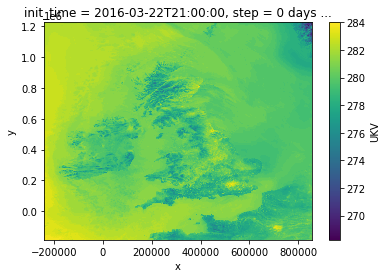

In [108]:
ds_from_zarr['UKV'].sel(variable='t').isel(step=0, init_time=0).astype(np.float32).plot.imshow()

In [109]:
ds_from_zarr['UKV'].encoding

{'chunks': (17, 1, 1, 352, 274),
 'preferred_chunks': {'variable': 17,
  'init_time': 1,
  'step': 1,
  'y': 352,
  'x': 274},
 'compressor': Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0),
 'filters': None,
 '_FillValue': nan,
 'dtype': dtype('float16')}

In [ ]:
ds_from_zarr['t']